# **Intro to ML using JAX**

<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo.png" width="50%" />


<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Introduction_to_ML_using_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:** Kale-ab Tessera

**Reviewers:** Javier Antoran, James Allingham, Ruan van der Merwe,
Sebastian Bodenstein, Laurence Midgley, Joao Guilherme and Elan van Biljon.   

**Introduction:**

In this tutorial, we will learn about JAX, a new machine learning framework that has taken deep learning research by storm! JAX is praised for its speed, and we will learn how to achieve these speedups, using core concepts in JAX, such as automatic differentiation (`grad`), parallelization (`pmap`), vectorization (`vmap`), just-in-time compilation (`jit`), and more. We will then use what we have learned to implement Linear Regression effectively while learning some of the fundamentals of optimization.

**Topics:**

Content: <font color='green'>`Numerical Computing`</font> , <font color='orange'>`Supervised Learning`</font>  
Level: <font color='grey'>`Beginner`</font>


**Aims/Learning Objectives:**

- Learn the basics of JAX and its similarities and differences with NumPy.
- Learn how to use JAX transforms - `jit`, `grad`, `vmap`, and `pmap`.
- Learn the basics of optimization and how to implement effective training procedures using [Haiku](https://github.com/deepmind/dm-haiku) and [Optax](https://github.com/deepmind/optax).   

**Prerequisites:**

- Basic knowledge of [NumPy](https://github.com/numpy/numpy).
- Basic knowledge of [functional programming](https://en.wikipedia.org/wiki/Functional_programming).

**Outline:**

>[Part 1 - Basics of JAX](#scrollTo=Enx0WUr8tIPf)

>>[1.1 From NumPy ➡ Jax - Beginner](#scrollTo=-ZUp8i37dFbU)

>>>[JAX and NumPy - Similarities  🤝](#scrollTo=CbOEYsWQ6tHv)

>>>[JAX and NumPy - Differences ❌](#scrollTo=lg4__l4A7yqc)

>>[1.2 Acceleration in JAX 🚀  - Beginner, Intermediate, Advanced](#scrollTo=TSj972IWxTo2)

>>>[JAX is backend Agnostic - Beginner](#scrollTo=_bQ9QqT-yKbs)

>>>[JAX Transformations  - Beginner, Intermediate, Advanced](#scrollTo=JM_08mXEBRIK)

>>>>[Basic JAX Transformations - jit and grad - Beginner](#scrollTo=cOGuGWtLmP7n)

>>>>[Pure Functions 💡  - Beginner](#scrollTo=fT56qxXzTVKZ)

>>>>[More Advanced Transforms - vmap and pmap - Intermediate, Advanced](#scrollTo=tvBzh8wiGuLf)


>[Part 2 - From Linear to Non-Linear Regression](#scrollTo=aB0503xgmSFh)

>>[2.1 Linear Regression - 📈 Beginner](#scrollTo=XrWSN-zaWAhJ)

>>>[Regression Toy Example - Housing Prices](#scrollTo=AcyM6XRj1cDz)

>>>[Optimization by Trial-and-Error](#scrollTo=vnoEkgimTQ6V)

>>>[Loss Function](#scrollTo=oLGAp30ZDnJ5)

>>>[Gradient descent: No more tuning parameters by hand!](#scrollTo=fg5Hi4783Gus)


>>[2.2 From Linear to Polynomial Regression - Intermediate](#scrollTo=Ao93xuXGJhLh)

>>>[Under-fitting](#scrollTo=CcXjMKi0Znr6)

>>>[Over-fitting](#scrollTo=uwwajy30U9fX)

>>[2.3 Training Models Using Haiku and Optax - Beginner](#scrollTo=sAtms17jtCOU)

>>>[Haiku](#scrollTo=exuVety_bFhQ)

>>>[Optax](#scrollTo=_3h034w5bWn6)

>>>[Full Training Loop Using Haiku and Optax 🧙](#scrollTo=7IaqVuRPg3ER)

>[Conclusion](#scrollTo=fV3YG7QOZD-B)

>[Appendix:](#scrollTo=XrRoSqlxfi7f)

>>[Derivation of partial derivatives for exercise 2.4.](#scrollTo=9OH9H7ndfuyQ)

>[Feedback](#scrollTo=o1ndpYE50BpG)


**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



## Installation and Imports

In [1]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import subprocess
import os

# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output('nvidia-smi')
    print("a GPU is connected.")
except Exception:
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
      print("A TPU is connected.")
      import jax.tools.colab_tpu
      jax.tools.colab_tpu.setup_tpu()
    else:
      print("Only CPU accelerator is connected.")
      # x8 cpu devices - number of (emulated) host devices
      os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

Only CPU accelerator is connected.


In [2]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [3]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


Text Cell below creates a LaTeX Macro to be used in math equations.

$$
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
$$

# **Part 1 - Basics of JAX**

**What is JAX?**

[JAX](https://jax.readthedocs.io/en/latest/index.html) is a python package for writing composable numerical transformations. It leverages [Autograd](https://github.com/hips/autograd) and [XLA](https://www.tensorflow.org/xla) (Accelerated Linear Algebra), to achieve high-performance numerical computing, which is particularly relevant in machine learning.

It provides functionality such as automatic differentiation (`grad`), parallelization (`pmap`), vectorization (`vmap`), just-in-time compilation (`jit`), and more. These transforms operate on [pure functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions), so JAX encourages a **functional programming** paradigm. Furthermore, the use of XLA  allows one to target different kinds of accelerators (CPU, GPU and TPU), without code changes.  

JAX is different from frameworks such as PyTorch or Tensorflow (TF). It is more low-level and minimalistic. JAX simply offers a set of primitives (simple operations) like `jit` and `vmap`, and relies on other libraries for other things e.g. using the data loader from PyTorch or TF. Due to JAX's simplicity, it is commonly used with higher-level neural network libraries such as [Haiku](https://github.com/deepmind/dm-haiku) or [Flax](https://github.com/google/flax). (Imagine writing complicated architectures using a NumPy-like interface alone! 😮 )   

## **1.1 From NumPy ➡ Jax** - <font color='blue'>`Beginner`</font>



### JAX and NumPy - Similarities  🤝

The main similarity between JAX and NumPy is that they share a similar interface and often, JAX and NumPy arrays can be used interchangeably.

#### Similiar Interface

Let's plot the sine functions using NumPy.

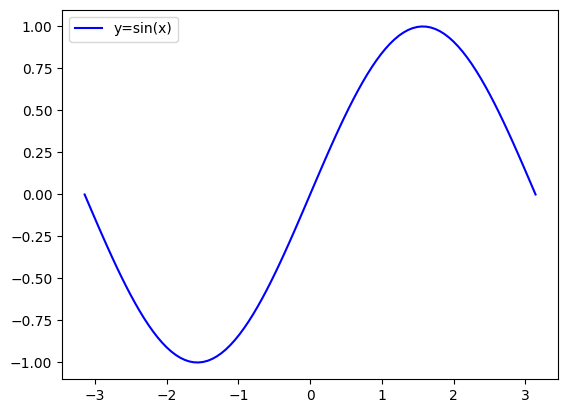

In [15]:
# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

Now using jax. We already imported `jax.numpy` as `jnp` in the first cell.

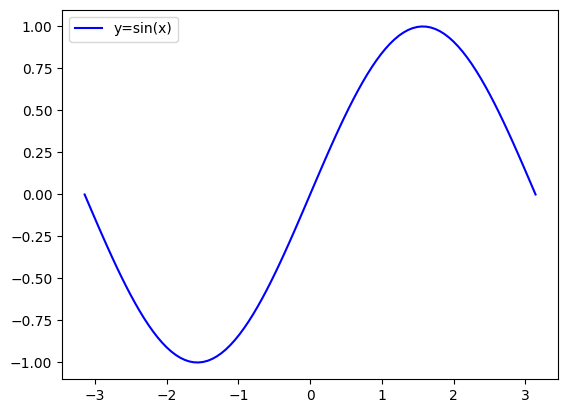

In [16]:
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

**Exercise 1.1 - Code Task:** Can you plot the cosine function using `jnp`?

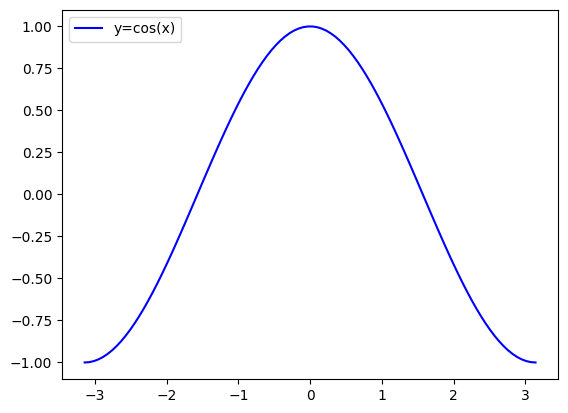

In [18]:
# Plot Cosine using jnp. (UPDATE ME)

# 100 linearly spaced numbers
# UPDATE ME
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# UPDATE ME
y = jnp.cos(x)


# plot the functions
plt.plot(x, y, "b", label="y=cos(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
# 100 linearly spaced numbers
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

y = jnp.cos(x)

# plot the functions
plt.plot(x, y, "b", label="y=cos(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

### JAX and NumPy - Differences ❌

Although JAX and NumPy have some similarities, they do have some important differences:
- Jax arrays are **immutable** (they can't be modified after they are created).
- The way they handle **randomness** -- JAX handles randomness explicitly.

#### JAX arrays are immutable, while NumPy arrays are not.

JAX and NumPy arrays are often interchangeable, **but** Jax arrays are **immutable** (they can't be modified after they are created). Allowing mutations makes transforms difficult and violates conditions for [pure functions](https://en.wikipedia.org/wiki/Pure_function).



Let's see this in practice by changing the number at the beginning of an array.

In [19]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


Let's try this in JAX.

In [20]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

Exception JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


So it fails! We can't mutate a JAX array once it has been created. To update JAX arrays, we need to use [helper functions](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html) that return an updated copy of the JAX array.

Instead of doing this `x[idx] = y`, we need to do this `x = x.at[idx].set(y)`.

In [21]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

 new_x: [10  1  2  3  4  5  6  7  8  9] original x: [0 1 2 3 4 5 6 7 8 9]


Note here that `new_x` is a copy and that the original `x` is unchanged.

#### Randomness in NumPy vs JAX

JAX is more explicit in Pseudo Random Number Generation (PRNG) than NumPy and other libraries (such as TensorFlow or PyTorch). [PRNG](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) is the process of algorithmically generating a sequence of numbers, which *approximate* the properties of a sequence of random numbers.  

Let's see the differences in how JAX and NumPy generate random numbers.

##### In Numpy, PRNG is based on a global `state`.

Let's set the initial seed.

In [22]:
# Set random seed
np.random.seed(42)
prng_state = np.random.get_state()

In [23]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

Let's take a few samples from a Gaussian (normal) Distribution and check if PRNG keys/global state change.

In [24]:
print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

sample 1 = 0.4967141530112327 Did prng state change: True
sample 2 = -0.13826430117118466 Did prng state change: True
sample 3 = 0.6476885381006925 Did prng state change: True


Numpy's global random state is updated every time a random number is generated, so *sample 1 != sample 2 != sample 3*.

Having the state automatically updated, makes it difficult to handle randomness in a **reproducible** way across different threads, processes and devices.

##### In JAX, PRNG is explicit.

In JAX, for each random number generation, you need to explicitly pass in a random key/state.

Passing the same state/key results in the same number being generated. This is generally undesirable.

In [25]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

sample 1 = -0.02830461598932743
sample 2 = -0.02830461598932743
sample 3 = -0.02830461598932743


To generate different and independent samples, you need to manually **split** the keys.

In [26]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

sample 1 = -0.02830461598932743
sample 2 = 0.6057640314102173
sample 3 = -0.21089035272598267


By using JAX, we can more easily reproduce random number generation in parallel across threads, processes, or even devices by explicitly passing and keeping track of the prng key (without relying on a global state that automatically gets updated). For more details on PRNG in JAX, you can read more [here](https://jax.readthedocs.io/en/latest/jep/263-prng.html).

## **1.2 Acceleration in JAX** 🚀  - <font color='blue'>`Beginner`</font>, <font color='orange'>`Intermediate`</font>, <font color='green'>`Advanced`</font>

JAX leverages Autograd and XLA for accelerating numerical computation. The use of Autograd allows for automatic differentiation (`grad`), while XLA allows JAX to run on multiple accelerators/backends and run transforms like `jit` and `pmap`. JAX also allows you to use `vmap` for automatic vectorization.  

### JAX is backend Agnostic - <font color='blue'>`Beginner`</font>

Using JAX, you can run the same code on different backends/AI accelerators (e.g. CPU/GPU/TPU), **with no changes in code** (no more `.to(device)` - from frameworks like PyTorch). This means we can easily run linear algebra operations directly on GPU/TPU.

**Multiplying Matrices**

Dot products are a common operation in numerical computing and a central part of modern deep learning. They are defined over [vectors](https://en.wikipedia.org/wiki/Coordinate_vector), which can loosely be thought of as a list of multiple scalers (single values).

Formally, given two vectors $\boldsymbol{x}$,$\boldsymbol{y}$ $\in R^n$, their dot product is defined as:

<center>$\boldsymbol{x}^{\top} \boldsymbol{y}=\sum_{i=1}^{n} x_{i} y_{i}$</center>

Dot Product in NumPy (will run on cpu)

In [32]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

62.6 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Dot Product using JAX (will run on current runtime - e.g. GPU).

In [33]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()

1.19 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



> When timing JAX functions, we use `.block_until_ready()` because JAX uses [asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch). This means JAX doesn't wait for the operation to complete before returning control to your code. To fairly compute the time taken for JAX operations, we therefore block until the operation is done.



How much faster was the dot product in JAX (Using GPU)?

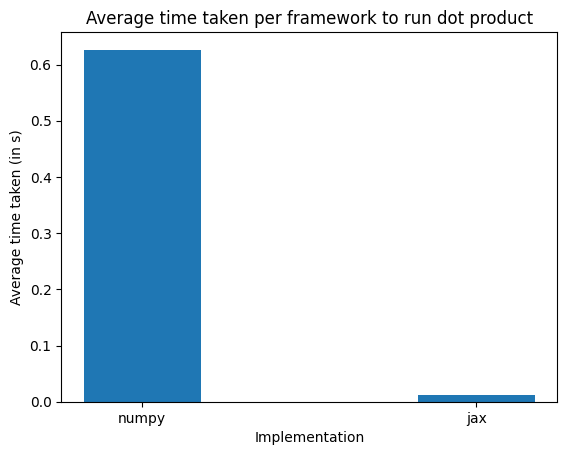

jax was 52.61 times faster than numpy !!!


In [34]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

JAX not running much faster? -> Re-run the JAX cell.                       
> "Keep in mind that the first time you run JAX code, it will be slower because it is being compiled. T*his is true even if you don’t use jit in your own code, because JAX’s builtin functions are also jit compiled*." - [JAX Docs](https://jax.readthedocs.io/en/latest/faq.html#benchmarking-jax-code).

If you are running on an accelerator, you should see a considerable performance benefit of using JAX, without making any changes to your code!







### JAX Transformations  - <font color='blue'>`Beginner`</font>, <font color='orange'>`Intermediate`</font>, <font color='green'>`Advanced`</font>

JAX transforms (e.g. jit, grad, vmap, pmap) first convert python functions into an intermediate language called *jaxpr*. Transforms are then applied to this jaxpr representation.

JAX generates jaxpr, in a process known as **tracing**. During tracing, function inputs are wrapped by a tracer object and then JAX records all operations (including regular python code) that occur during the function call. These recorded operations are used to reconstruct the function.

Any python side-effects are not recorded during tracing. JAX transforms and compilations are designed to work only with **pure functions**. For more on tracing and jaxpr, you can read [here](https://jax.readthedocs.io/en/latest/jaxpr.html).



#### Basic JAX Transformations - `jit` and `grad` - <font color='blue'>`Beginner`</font>

In this section, we will explore two basic JAX transforms:
- jit (Just-in-time compilation) - compiles and caches JAX Python functions so that they can be run efficiently on XLA to *speed up function calls*.
- grad - *Automatically* compute *gradients* of functions.

##### jit

Jax dispatches operations to accelerators one at a time. If we have repeated operations, we can use `jit` to compile the function the first time it is called, then subsequent calls will be [cached](https://en.wikipedia.org/wiki/Cache_(computing) (save the compiled version so that it doesn't need to be recompiled everytime we call it).

Let's compile [ReLU (Rectified Linear Unit)](https://arxiv.org/abs/1803.08375), a popular activation function in deep learning.

ReLU is defined as follows:
<center>$f(x)=max(0,x)$</center>

It can be visualized as follows:

<center>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="35%" />
</center>,

where $x$ is the input to the function and $y$ is output of ReLU.


$$f(x)=\max (0, x)=\left\{\begin{array}{l}x_{i} \text { if } x_{i}>0 \\ 0 \text { if } x_{i}<=0\end{array}\right.$$

**Exercise 1.2 - Code Task:** Complete the ReLU implementation below using standard python.

In [35]:
# Implement ReLU.
def relu(x):
    if x > 0:
        return x
        # TODO Implement me!
    else:
        return 0
        # TODO Implement me!

Your ReLU function is correct!


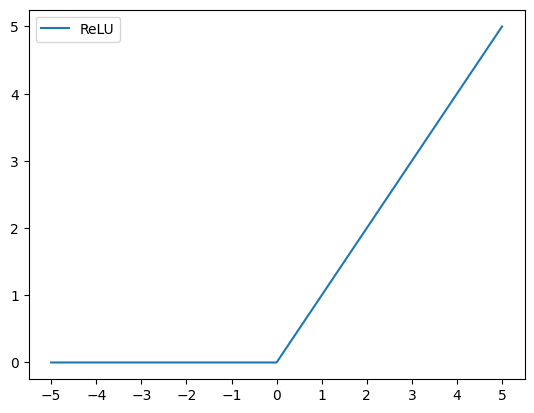

In [36]:
# @title Run to test your function.


def plot_relu(relu_function):
    max_int = 5
    # Generete 100 evenly spaced points from -max_int to max_int
    x = np.linspace(-max_int, max_int, 1000)
    y = np.array([relu_function(xi) for xi in x])
    plt.plot(x, y, label="ReLU")
    plt.legend(loc="upper left")
    plt.xticks(np.arange(min(x), max(x) + 1, 1))
    plt.show()


def check_relu_function(relu_function):
    # Generete 100 evenly spaced points from -100 to -1
    x = np.linspace(-100, -1, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert (y == 0).all()

    # Check if x == 0
    x = 0
    y = relu_function(x)
    assert y == 0

    # Generete 100 evenly spaced points from 0 to 100
    x = np.linspace(0, 100, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert np.allclose(x, y)

    print("Your ReLU function is correct!")


check_relu_function(relu)
plot_relu(relu)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    if x > 0:
        return x
    else:
        return 0


check_relu_function(relu)
plot_relu(relu)

Let's try to `jit` this function to speed up compilation and then try to call it.

In [37]:
relu_jit = jax.jit(relu)

key = jax.random.PRNGKey(42)
# Gen 1000000 random numbers and pass them to relu
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# Should raise an error.
try:
    relu_jit(x)
except Exception as e:
    print("Exception {}".format(e))

Exception The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


**Why does this fail?**


> As mentioned above, JAX transforms first converts python functions into an intermediate language called *jaxpr*. Jaxpr only captures what is executed on the parameters given to it during tracing, so this means during conditional calls, jaxpr only considers the branch taken.
>
> When jit-compiling a function, we want to compile and cache a version of the function that can handle multiple different argument types (so we don't have to recompile for each function evaluation). For example, when we compile a function on an array `jnp.array([1., 2., 3.], jnp.float32)`, we would likely also want to use the compiled function for `jnp.array([4., 5., 6.], jnp.float32)`.
>
> To achieve this, JAX traces your code based on abstract values. The default abstraction level is a ShapedArray - array that has a fixed size and dtype, for example, if we trace a function using `ShapedArray((3,), jnp.float32)`,  it can be reused for any concrete array of size 3, and float32 dtype.
>
> This does come with some challenges. Tracing that relies on concrete values becomes tricky and sometimes results in `ConcretizationTypeError` as in the ReLU function above. Furthermore, when tracing a function with conditional statements ("if ..."), JAX doesn't know which branch to take when tracing and so tracing can't occur.

**TLDR**: JAX tracing doesn't work well with conditional statements ("if ...").



To solve this, we have two options:
- Use static arguments to make sure JAX traces on a concrete value level - this is not ideal if you need to retrace a lot. Example - bottom of this [section](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit).
- Use builtin JAX condition flow primitives such as [`lax.cond`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html) or [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html).  

**Exercise 1.3 - Code Task** : Let's convert our ReLU function above to work with jit.

**Useful methods:**  [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html) (or [`jnp.maximum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.maximum.html), if you prefer.)

In [42]:
# Implement a jittable ReLU
def relu(x):
    # TODO Implement ME!
    return jnp.where(x>0, x, 0)

In [43]:
# @title Run to test your function.
check_relu_function(relu)

Your ReLU function is correct!


In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)


check_relu_function(relu)

The slowest run took 20.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1.8 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 µs ± 8.56 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


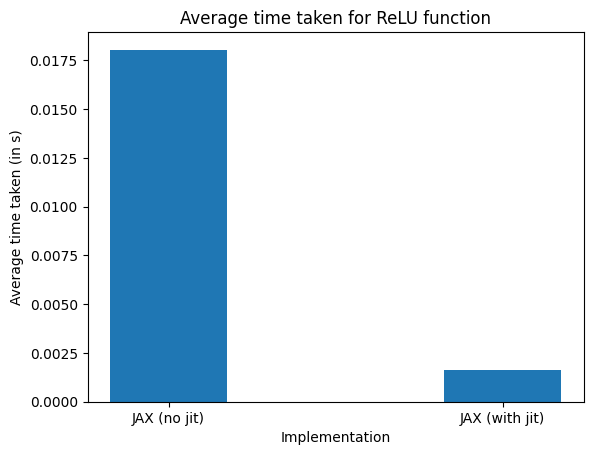

JAX (with jit) was 11.06 times faster than JAX (no jit) !!!


In [44]:
# @title Now let's see the performance benefit of using jit! (Run me)

# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

##### grad

`grad` is used to automatically compute the gradient of a function in JAX. It can be applied to Python and NumPy functions, which means you can differentiate through loops, branches, recursion, and closures.  

`grad` takes in a function `f` and returns a function. If `f` is a mathematical function $f$, then `grad(f)` corresponds to $f'$ (Lagrange's notation), with `grad(f)(x)` corresponding to $f'(x)$.


Let's take a simple function $f(x)=6x^4-9x+4$

In [45]:
f = lambda x: 6 * x**4 - 9 * x + 4

We can compute the gradient of this function - $f'(x)$ and evaluate it at $x=3$.

In [46]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

**Exercise 1.4 - Math Task**: Can you calculate $f'(2)$ by hand?

In [49]:
answer = 183  # @param {type:"integer"}

dfdx_2 = dfdx(2.0)

assert (
    answer == dfdx_2
), "Incorrect answer, hint https://en.wikipedia.org/wiki/Power_rule#Statement_of_the_power_rule"

print("Nice, you got the correct answer!")

Nice, you got the correct answer!


In [50]:
# @title Answer to math task (Try not to run until you've given it a good try!')
%%latex
\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\
f'(2) &  = 24(2)^3 -9 = 183 && \triangleright \textrm{Substituting x=2} \\
\end{aligned}

<IPython.core.display.Latex object>

We can also chain `grad` to calculate higher order deratives.

We can calculate $f'''(x)$ as follows:

In [51]:
d3dx = grad(grad(grad(f)))

**Exercise 1.5 - Math Task**: How about $f'''(2)$ by hand?

In [54]:
answer = 288  # @param {type:"integer"}

d3dx_2 = d3dx(2.0)

assert answer == d3dx_2, "Incorrect answer, hint ..."

print("Nice, you got the correct answer!")

Nice, you got the correct answer!


In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!')
%%latex

\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\
f''(x) & = 72x^2  && \triangleright \textrm{Power Rule.}  \\
f'''(x) & = 144x && \triangleright \textrm{Power Rule.} \\
f'''(2) & = 144(2)=288 && \triangleright \textrm{Substituting x=2} \\
\end{aligned}

Another useful method is `value_and_grad`, where we can get the value ($f(x)$) and gradient ($f'(x)$).

In [55]:
from jax import value_and_grad

f_x, dy_dx = value_and_grad(f)(2.0)
print(f"f(x): {f_x} f′(x): {dy_dx} ")

f(x): 82.0 f′(x): 183.0 


> For partial derivatives, you need to use the [`argnums`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) param to specify which variables you want to differentiate with respect to.



**Exercise 1.6 - Group Task:** Chat with neighbour/think about how JAX's automatic differentiation compares to other libraries such as Pytorch or Tensorflow.

Another useful application related to `grad` is when you want your `grad` function to return auxiliary (extra) data, that you don't want differentiated. You can use the `has_aux` parameter to do this (example in "Auxiliary data" section in [here](https://github.com/google/jax/blob/main/docs/jax-101/01-jax-basics.ipynb)).

#### Pure Functions 💡  - <font color='blue'>`Beginner`</font>

So we have learned about `jit` and `grad`. Before we move on, let's make sure we understand [**pure functions**](https://en.wikipedia.org/wiki/Pure_function).

JAX transformation and compilation are designed to work reliably on **pure functions**. These functions have the following properties:
1. All **input** data is passed through the **function's parameters**.
2. All **results** are output through the **function's return**.
3. The function always returns the same **result** if invoked with the **same inputs**. What if your function involves randomness? Pass in the random seed!
4. **No [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science))** - no mutation of non-local variables or input/output streams.  

Let's see what could happen if we don't stick to using pure functions.

##### Side Effects

Let's call print within a function.

In [56]:
def impure_print_side_effect(x):
    print("Print me!")  # This is a side-effect
    return x


# The side-effects appear during the first run
print("First call: ", jax.jit(impure_print_side_effect)(4.0))

Print me!
First call:  4.0


As expected, the print statement is called.

Let's call this function again.

In [57]:
# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print("Second call: ", jax.jit(impure_print_side_effect)(5.0))

Second call:  5.0


Ah, no print statement! Since JAX cached the compilation of the function, `print()` calls will only happen during tracing and not every time the function is called.

In [58]:
# JAX re-runs the Python function when the type or shape of the argument changes
print(
    "Third call, different type: ", jax.jit(impure_print_side_effect)(jnp.array([5.0]))
)

Print me!
Third call, different type:  [5.]


In this case, we called the function with a different shaped object and so it triggered the re-tracing of the function and print was called again.

To print values in compiled functions, use [host callbacks](https://jax.readthedocs.io/en/latest/jax.experimental.host_callback.html?highlight=print#jax.experimental.host_callback.id_print)([example](https://github.com/google/jax/issues/196#issuecomment-1191155679)) or if your jax version>=0.3.16, you can use [`jax.debug.print`](https://jax.readthedocs.io/en/latest/debugging/print_breakpoint.html).


##### Globals

Using global variables can also lead to some undesired consequences!

In [59]:
g = 0.0


def impure_uses_globals(x):
    return x + g


# JAX captures the value of the global during the first run
print("First call: ", jax.jit(impure_uses_globals)(4.0))

First call:  4.0


This prints 4, using the original value of `g`.

Let's update `g` and call our function again.

In [60]:
g = 10.0  # Update the global

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jax.jit(impure_uses_globals)(4.0))

Second call:  4.0


Even though we updated our global variable, this still prints 4, using the original value of `g`. This is because the value of `g` was cached.

In [61]:
# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", jax.jit(impure_uses_globals)(jnp.array([4.0])))

Third call, different type:  [14.]


Similar to the side-effects example, re-tracing gets triggered when the shape of our input has changed. In this case, our function now uses the updated value of `g`.

Since the global variables are cached, it is still okay to use global **constants** inside jax functions.

#### JAX transforms <-> Pure Functions
In summary, JAX transforms should only be used with pure functions!

#### More Advanced Transforms - `vmap` and `pmap` - <font color='orange'>`Intermediate`</font>, <font color='green'>`Advanced`</font>

JAX also provides transforms that allow you automatically vectorize (`vmap`) and parallelize (`pmap`) your code.

##### vmap - <font color='orange'>`Intermediate`</font>

vmap (Vectorizing map) automatically vectorizes your python functions.

Let's define a simple function that calculates the min and max of an input.

In [62]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

We can apply this function to the vector - `[0, 1, 2, 3, 4]` and get the min and max values.

In [63]:
x = jnp.arange(5)
min_max(x)

Array([0, 4], dtype=int32)

What about if we want to apply this to a batch/list of vectors (i.e. calculate the min and max independently across multiple batches)?

Let's create our batch - 3 vectors of size 5.

In [64]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


**Exercise 1.7 - Question**: What do you think would be the result if we passed batch_x into `min_max`?

In [65]:
batch_min_max_output = [0,14]  # @param ["[[0,4],[5,9],[10,14]]", "[[0,10],[1,11],[2,12],[3,13],[4,14]]", "[0,14]"] {type:"raw"}

assert (batch_min_max_output == np.array(min_max(batched_x))).all(), "Incorrect answer."

print("Nice, you got the correct answer!")

Nice, you got the correct answer!


So the above is not what we want. The `min` and `max` is applied across the entire batch, when we want the min and max per vector/mini-batch.

We can also manually batch this by `jnp.stack` and a for loop, as follows:

In [66]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


Or, just manually updating the `axis` in `jnp.min` and `jnp.max`.

In [67]:
@jit
def manual_batch_min_max_axis(batched_x):
    return jnp.array([jnp.min(batched_x, axis=1), jnp.max(batched_x, axis=1)]).T


print(manual_batch_min_max_axis(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


These approaches both work, but we need to change our function to work with batches. We can't just run the same code across a batch of data.

There is where `vmap` becomes useful! Using `vmap` we can write a function once, as if it is working on a single element, and then use `vmap` to automatically vectorize it!

In [68]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

Single vector: [[0 4]]
Batch/list of vector:[[ 0  4]
 [ 5  9]
 [10 14]]


So this is really convenient, but what about performance?

In [69]:
batched_x = np.arange(50000).reshape((500, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_axis_time = %timeit -o -n 10 manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Manually Vectorized: {np.round(np.mean(min_max_axis_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

1.12 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
301 µs ± 9.05 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
297 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Avg Times (lower is better) - Naive Implementation: 0.01123 Manually Vectorized: 0.00301 Vmapped Function: 0.00297 


So `vmap` should be similar in performance to manually vectorized code (if everything is implemented well), and much better than naively vectorized code (i.e. for loops).

##### pmap - <font color='green'>`Advanced`</font>

💡**For this subsection, please ensure that colab is using a `TPU` runtime. If no `TPU` runtimes are available, select `Harware Accelerator` - `None` for a cpu runtime.**

Another JAX transform is `pmap`. `pmap` transforms a function written for one device, to a function that can run in parallel, across many devices.

**Difference between `vmap` and `pmap`**:

So both `pmap` and `vmap` transform a function to work over an array, but they differ in implementation. `vmap` adds an extra batch dimension to all the operations in a function, while `pmap` replicates the function and executes each replica on its own XLA device in parallel.

In [5]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


Let's try and `pmap` a batch of dot products.

Here is an illustration of how we would typically do this sequentially:

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [6]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Here is the code implementation of this:

In [7]:
# Let's generate a batch of size 8, each with a matrix of size (500, 600)

# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

368 ms ± 74.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Here is an illustration of how we would do this in parallel

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [ ]:
# @title Illustration of Parallel Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/parallelized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

Here is code implementation of batched dot products:

First, we will create `8` random matrices (one for each available tpu devices - colab tpu's have 8 available [devices](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm) or the 8 cpu cores as we configured).

In [8]:
# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

The leading dimension here needs to equal the dimension of available devices (since we are sending a batch to each device).

In [9]:
print(mats.shape)

(8, 500, 600)


Using `pmap` to generate the batches ensures these batches are of type `ShardedDeviceArray`. This is similar to an ndarray, except each batch/shared is stored in the memory of multiple devices, so they can be used in subsequent `pmap` operations without moving data around between devices (GPU/TPU) and hosts (cpu).

In [10]:
print(type(mats))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [11]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

62 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


It is simple as that. Our dot product now runs in parallel across available devices (cpu, gpus or tpus). As we have more cores/devices, this code will automatically scale!

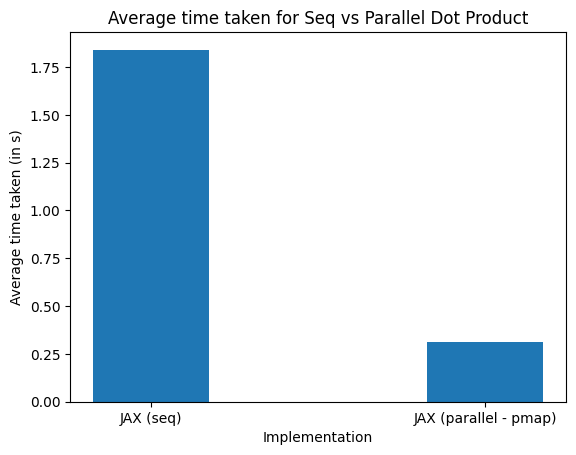

JAX (parallel - pmap) was 5.93 times faster than JAX (seq) !!!


In [12]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

For some problems, the speed can be directly proportional to the number of devices -- $Nx$ speed up for $N$ devices!

We showed an example of using `pmap` for *pure* parallelism, where there is no communication between devices. JAX also has various operations for communication across distributed devices ( more on this [here](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#communication-between-devices).)

# **Part 2 - From Linear to Non-Linear Regression**

Now that we know some basics of JAX, we can build some simple models!

We will start by learning the basics of Linear Regression and then move on to Polynomial Regression. Finally, we will show how we can use [Haiku](https://github.com/deepmind/dm-haiku) and [Optax](https://github.com/deepmind/optax) to make training our models simpler and more convenient.  

## **2.1 Linear Regression** - 📈 <font color='blue'>`Beginner`</font>

With a long history spanning from the 19th century [[Gauss, 1809](https://cir.nii.ac.jp/crid/1573950399668535168), [Legendre, 1805](https://play.google.com/store/books/details?id=7C9RAAAAYAAJ&rdid=book-7C9RAAAAYAAJ&rdot=1)] , linear regression is one of the simplest and most popular methods for solving regression problems (problems where we  are predicting a continuous variable).   

Linear regression aims to find a function $f$ that maps our **inputs $x$**, where $x \in R^D$ (*$x$ is a real number of dimension $D$*), to the corresponding **output/target - $y$**, where $y \in R^1$ (output is a single real number).

Put simply, we are trying to model the relationship between one or more independent variables (our inputs - $x$) and our dependent variable (our output - $y$). In Machine Learning, we model this relationship so that we can make predictions.

For simplicity, we will focus on simple Linear Regression, where we have a single input $x$ ($x \in R^1$).

### Regression Toy Example - Housing Prices

Let's say we have a dataset of housing sizes (in $m^2$) and their prices (in 100 000s of Tunisian dinar - TND).

|Size of House in $m^2$ (input - $x$) | Price (100 000s of TND) (output - $y$)  
--- | --- |
|210|4|
|160|3.3|
|240|3.7|
|140|2.3|
|300|5.4|

Let's build this simple dataset, with 5 elements.

In [ ]:
x_data_list = [210, 160, 240, 140, 300]
y_data_list = [4, 3.3, 3.7, 2.3, 5.4]

In [ ]:
# @title Let's plot our dataset. (Run Cell)
def plot_basic_data(parameters_list=None, title="Observed data", axis_pad=1):
    xlim = [min(x_data_list) - axis_pad, max(x_data_list) + axis_pad]
    ylim = [min(y_data_list) - axis_pad, max(y_data_list) + axis_pad]
    fig, ax = plt.subplots()

    if parameters_list is not None:
        x_pred = np.linspace(xlim[0], xlim[1], 100)
        for parameters in parameters_list:
            y_pred = parameters[0] + parameters[1] * x_pred
            ax.plot(x_pred, y_pred, ":", color=[1, 0.7, 0.6])

        parameters = parameters_list[-1]
        y_pred = parameters[0] + parameters[1] * x_pred
        ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

    ax.plot(x_data_list, y_data_list, "ob")
    ax.set(xlabel="Input x", ylabel="Output y", title=title, xlim=xlim, ylim=ylim)
    ax.grid()


plot_basic_data()

### **Optimization by Trial-and-Error**

Let's say we would like to predict these $y$ (outputs) values given the $x$ (inputs).

We can start modeling this by using a simple linear function:
<center>
$f(x) = \color{red}{w} x + \color{red}{b}$
</center>

, where $x$ is our inputs and  $\color{red}{b}$ and $\color{red}{w}$ are our model parameters.

Usually, we learn the model parameters, but let's try to find these parameters by hand!

In [ ]:
# RUN ME
parameters_list = []  # Used to track which parameters were tried.

**Exercise 2.1**
1. Move the two sliders below to set $\color{red}{b}$ and $\color{red}{w}$.
2. Is your $f(x)$ close to the blue data points? Can you find a better fit?
3. Repeat 1-2 until you have found a good enough fit.

In [ ]:
# @title Choose model parameters. { run: "auto" }
b = 3  # @param {type:"slider", min:-5, max:5, step:1}
w = -0.03  # @param {type:"slider", min:-0.05, max:0.05, step:0.01}
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(
    parameters_list, title="Observed data and my first predictions", axis_pad=12
)

**Weights and Bias**

What was the impact of changing $\color{red}{b}$ and $\color{red}{w}$?

- $\color{red}{w}$ is our weights. This represents the slope of our function.
- $\color{red}{b}$ is our bias (also called the *intercept*). This is the value of our model when all features are zero ($x=0$). This shifts the line, without changing the slope.

**You're a born optimizer!**

In [ ]:
# @title Let's plot the optimization trajectory you took. (Run Cell)
fig, ax = plt.subplots()
opt = {
    "head_width": 0.01,
    "head_length": 0.2,
    "length_includes_head": True,
    "color": "r",
}
if parameters_list is not None:
    b_old = parameters_list[0][0]
    w_old = parameters_list[0][1]
    for i in range(1, len(parameters_list)):
        b_next = parameters_list[i][0]
        w_next = parameters_list[i][1]
        ax.arrow(b_old, w_old, b_next - b_old, w_next - w_old, **opt)
        b_old, w_old = b_next, w_next

    ax.scatter(b_old, w_old, s=200, marker="o", color="y")
    bs = [parameters[0] for parameters in parameters_list]
    ws = [parameters[1] for parameters in parameters_list]
    ax.scatter(bs, ws, s=40, marker="o", color="k")

ax.set(
    xlabel="Bias b",
    ylabel="Weight w",
    title="My sequence of b's and w's",
    xlim=[-5, 5],
    ylim=[-0.05, 0.05],
)
plt.show()

**Exercise 2.2 - Group Task**:

*How did your neighbour do?*
- Did they change $\color{red}{b}$ and $\color{red}{w}$ with big steps or small steps each time?
- Did they start with small steps, and then progressed to bigger steps? Or the other way round? What about you?
- Did the magnitude of your previous steps influence your next choice? Why? Or why not?
- Did you all converge to roughly the same endpoint for $\color{red}{b}$ and $\color{red}{w}$, or did your sequences end up in different places?

### **Loss Function**

You tweaked $\color{red}{b}$ and $\color{red}{w}$ to find a good fit by hand. This isn't optimal (*imagine doing this for 10s to 1000s of parameters*), so we would like to automate this learning process.

Before we discuss how to fit the model, we need to determine a measure of fitness, also referred to as a **loss function**. This loss quantifies the difference between the predictions that our model made ($f(x)$) and the true values/targets ($y$).

When you manually adjusted your weights $\color{red}{b}$ and $\color{red}{w}$, you probably looked at how close each $f(x)$ was to the $y$ that it tries to predict.
Maybe you glanced at the distance from the red line to each of the blue dots, and imagined the average of the distances (marked in purple) below. If the average was small, your fit was good!


<img src='https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2022/main/images/Introduction_to_ML_using_JAX/loss-function-intro.png' width='600'>



> Notation Reminder:
- $x$ - our inputs.
- $f(x)$ or $\hat{y}$ - our model predictions.
- $y$ - the value we are trying to predict/our targets.  

#### **Formalizing the Loss Function**

**Indexing**

To formalize this notion, from the image above, let $x_1 = 1$, $x_2 = 2$, $x_3 = 3$... and let $y_1 = 3$, $y_2 = 2$, $y_3 = 3$... The blue dots are therefore a sequence of input-output $(x, y)$ pairs.
Assuming that the order of the data points doesn't matter, and $i = 1, ..., N$ (where $N=5$ in our case) indexes the data, e.g. $x_1,y_1$ refer to the input and output of the first element in our dataset (e.g. $x_1,y_1$ is (1,3) in the image).

**Error**

The <font color='green'>green lines</font> above, also known as **error** or **cost**, tell us the distance between the prediction and target value for a specific example (i.e how well the prediction matches the real data). A long line means that we have a large error and our prediction for that example is not optimal, while a short line indicates our prediction is close to the true label.

In the image, the error is simply the distance between the true label and our model's prediction ( $y$ - $f(x)$), but there can be various formulations of the error term. A popular function is the squared error.

Squared error can be formulated as follows:
<center>
$\mathrm{error}(\color{red}{b}, \color{red}{w} ; x_i, y_i) = (y_i - \underbrace{(\color{red}{w} x_i + \color{red}{b})}_{f(x_i)})^2$
</center>

, where $\color{red}{b}$ and $\color{red}{w}$ are our parameters, $x_i,y_i$ is the specific input, output pair that we are calculating the error for.  



**Exercise 2.3 - Code Task:** Implement Squared Error, using the formulae above.

**Useful methods:**  [`jnp.dot`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.dot.html).

In [ ]:
def squared_error(b, w, x, y):
    # first calculate f(x_i), also sometimes referred to as yhat
    yhat = ...
    # then calculate the squared error
    error = ...
    return error

In [ ]:
# @title Check if answer is correct (Run me)!


def check_squared_error(squared_error):
    b = 3.77
    w = 0.05

    correct_error = [105.47291, 71.740906, 145.68492, 71.740906, 178.75693]

    for i in range(len(x_data_list)):
        x_i = x_data_list[i]
        y_i = y_data_list[i]
        error = squared_error(b, w, x_i, y_i)
        assert jnp.equal(
            error, correct_error[i]
        ), f"Incorrect implementation. Value: {error} Expected Value: {correct_error[i]}. Parameters (b,w,x_i,y_i): {b,w,x_i,y_i} "

    print("Implementation is correct!")


check_squared_error(squared_error)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def squared_error(b, w, x, y):
    yhat = jnp.dot(w, x) + b
    error = jnp.square(yhat - y)
    return error


check_squared_error(squared_error)

**Loss Function - Mean Squared Error**

Now we have a way to quantify the error of our model per **example**. However, what we really care about is the quality of our model across our **entire training dataset**. Like there are many types of error functions, there are also many ways to quantify our loss across the whole dataset.

A common loss function is **mean squared error (MSE)**, where we simply average the error across the training set.

**MSE** is formulated as follows:
<center>
$\mathrm{loss}(\color{red}{b}, \color{red}{w}) = \frac{1}{ \color{blue}{2}N} \sum_{i=1}^N \Big(y_i - \underbrace{(\color{red}{w} x_i + \color{red}{b})}_{f(x_i)} \Big)^2$,
</center>

where $N$ is our number of training examples and $\color{blue}{\frac{1}{2}}$ is a constant factor that makes taking the derivative more convenient (more on this later).


**Plot our loss**

Let's code our loss function.

In [ ]:
# MSE
def loss(b, w):
    # init loss of size of b
    loss = 0 * b
    for x, y in zip(x_data_list, y_data_list):
        loss += squared_error(b, w, x, y)
    N = len(x_data_list)
    return loss / (2 * (N))

Now that we have a loss function, we can plot the loss of our model, using the sequence of manually chosen values of $\color{red}{b}$ and $\color{red}{w}$ from above.

In [ ]:
# @title Plot our Loss (Run Me)
from matplotlib import cm

bs, ws = np.linspace(-5, 5, num=25), np.linspace(-0.05, 0.05, num=25)
b_grid, w_grid = np.meshgrid(bs, ws)
loss_grid = loss(b_grid, w_grid)


def plot_loss(parameters_list, title, show_stops=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": "3d"})
    ax[0].view_init(10, -30)
    ax[1].view_init(30, -30)

    if parameters_list is not None:
        b_old = parameters_list[0][0]
        w_old = parameters_list[0][1]
        loss_old = loss(b_old, w_old)
        ls = [loss_old]

        for i in range(1, len(parameters_list)):
            b_next = parameters_list[i][0]
            w_next = parameters_list[i][1]
            loss_next = loss(b_next, w_next)
            ls.append(loss_next)

            ax[0].plot(
                [b_old, b_next],
                [w_old, w_next],
                [loss_old, loss_next],
                color="red",
                alpha=0.8,
                lw=2,
            )
            ax[1].plot(
                [b_old, b_next],
                [w_old, w_next],
                [loss_old, loss_next],
                color="red",
                alpha=0.8,
                lw=2,
            )
            b_old, w_old, loss_old = b_next, w_next, loss_next

        if show_stops:
            ax[0].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
            ax[1].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
            bs = [parameters[0] for parameters in parameters_list]
            ws = [parameters[1] for parameters in parameters_list]
            ax[0].scatter(bs, ws, ls, s=40, marker="o", color="k")
            ax[1].scatter(bs, ws, ls, s=40, marker="o", color="k")
        else:
            ax[0].scatter(b_old, w_old, loss_old, s=40, marker="o", color="k")
            ax[1].scatter(b_old, w_old, loss_old, s=40, marker="o", color="k")

    ax[0].plot_surface(
        b_grid,
        w_grid,
        loss_grid,
        cmap=cm.coolwarm,
        linewidth=0,
        alpha=0.4,
        antialiased=False,
    )
    ax[1].plot_surface(
        b_grid,
        w_grid,
        loss_grid,
        cmap=cm.coolwarm,
        linewidth=0,
        alpha=0.4,
        antialiased=False,
    )
    ax[0].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
    ax[1].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
    plt.show()


plot_loss(
    parameters_list,
    "An example loss function and my sequence of b's and w's",
    show_stops=True,
)

Your sequence of choices for $\color{red}{b}$ and $\color{red}{w}$ are also plotted on the $(\color{red}{b}, \color{red}{w})$ axis.
Does your sequence progressively move toward a parameter setting for which the loss function is small?
We plotted two views of the loss function, so that it is easier to see the minimum *and* the function.

### **Gradient descent: No more tuning parameters by hand!**

When you manually tweaked $\color{red}{b}$ and $\color{red}{w}$, you tried to adjust your model to find a better fit. If you were an experienced manual parameter adjuster, you might even have adjusted the $\color{red}{b}$ and $\color{red}{w}$ so that the fit gets *better* with each adjustment.

Gradient descent is a method that tries to minimize the loss function by iteratively updating our weights $\color{red}{b}$ and $\color{red}{w}$. How do we know how to update our weights? That is where **gradients** come in! The gradients of the weights tell us how to update their values in order to minimize our loss.


##### **Gradients**
Using our **loss**, we would like to know how to adjust  $\color{red}{b}$ **and** $\color{red}{w}$ in order to minimize our loss. We can use partial derivatives and the chain rule to figure out how to update our parameters.

> **Partial derivatives** are used when we have a function of several variables and we want to know how a function changes as a result of a specific variable. To calculate this, we take the derivative of the loss, with respect to one of those variables, with the others variables held constant. If we know this for all the variables in our loss function, we can update our parameters to decrease our loss.
>
> For example, for a function $f(x,y)$, $\frac{\partial{f}}{\partial{x}}$ (*read partial derivative of $f$ with respect to $x$*), tells us how $f$ changes with respect to changes in $x$ and $\frac{\partial{f}}{\partial{y}}$, tells us how $f$ changes with respect to changes in $y$.  


> The **chain rule** tells us how to differentiate composite functions (functions of a functions/function within a function). The rule is as follows: $$\frac{d}{d x}[f(g(x))]=f^{\prime}(g(x)) g^{\prime}(x)$$


You can read more here - [partial derivatives](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivative-and-gradient-articles/a/introduction-to-partial-derivatives), the [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review) and [practical on optimization](https://github.com/deep-learning-indaba/indaba-pracs-2019/blob/master/1b_build_tensorflow.ipynb).


**Exercise 2.4 - (Optional) Math Task:**

Using our loss,

<center>
$\mathrm{loss}(\color{red}{b}, \color{red}{w}) = \frac{1}{ \color{blue}{2}N} \sum_{i=1}^N \Big(y_i - \underbrace{(\color{red}{w} x_i + \color{red}{b})}_{f(x_i)} \Big)^2$,
</center>

Can you derive
$\frac{\partial \mathcal{L}}{\partial w}$ and $\frac{\partial \mathcal{L}}{\partial b}$ by hand? *For notation simplicity, we will refer to the loss $\mathrm{loss}(\color{red}{b}, \color{red}{w})$ as $\mathcal{L}$.*

**Useful methods:** [Partial derivatives](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivative-and-gradient-articles/a/introduction-to-partial-derivatives), [Sum Rule](https://www.khanacademy.org/math/old-ap-calculus-ab/ab-derivative-rules/ab-basic-diff-rules/a/basic-differentiation-review) and the [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review).





**Answer to math task** -  Once you have given it a try, you can see the full derivation [here](#scrollTo=9OH9H7ndfuyQ).

The two gradients we need are as follows:
\begin{aligned}
&\frac{\partial \mathcal{L}}{\partial w}=\frac{1}{N} \sum_{i=1}^{N}\left(f(x_i)-y_i\right) x_i \\
&\frac{\partial \mathcal{L}}{\partial b}=\frac{1}{N} \sum_{i=1}^{N} f(x_i)-y_i
\end{aligned}

In the code snippet below, we compute the two gradients using a for-loop over examples. This is just to illustrate how the gradient is computed. Very soon, we'll throw away the for-loop over data points and do it "all at once" in vectorized operations!

In [ ]:
def manual_grad(b, w):
    grad_b = 0
    grad_w = 0
    for x, y in zip(x_data_list, y_data_list):
        f = w * x + b
        grad_b += f - y
        grad_w += (f - y) * x
    grad_b /= len(x_data_list)
    grad_w /= len(x_data_list)
    return grad_b, grad_w

##### **Gradient Descent**

Not that we have the gradients, we can use gradient descent. The general idea is to start with an initial value/guess for the model weights and then repeatedly use the gradients to tweak the parameters $\color{red}{b}$ and $\color{red}{w}$ in the right direction.  

These updates can be formulated as follows:

$$\color{red}{b} \leftarrow \color{red}{b} - \color{blue}{\eta} \frac{\partial \mathcal{L}}{\partial \color{red}{b}} $$

$$\color{red}{w} \leftarrow \color{red}{w} - \color{blue}{\eta} \frac{\partial \mathcal{L}}{\partial \color{red}{w}} $$

, where $\color{blue}{\eta}$ is the **learning rate** and just tells us how much we are going to scale the gradient before we use it to update our parameters:
are we going to try to walk downhill with big steps or small steps?

**Exercise 2.5**
1. Run the code snippet below, and note the $(\color{red}{b}, \color{red}{w})$ trajectory as we use the gradient to (try to) get to the minimum.
2. Adjust the starting values for $\color{red}{b}$ or $\color{red}{w}$ or the value of $\color{blue}{\eta}$ and see how the resulting trajectory to the minimum changes.
3. Can you find a setting for $\color{blue}{\eta}$ where things start spiraling out of control and the loss gets bigger and bigger (and not smaller)?
4. Can you find a setting for $\color{blue}{\eta}$ so that we're still far away from the minimum after `200` parameter update steps?
5. Play around with the `max_grad` variable. Do we always need this? What problem does this solve? (Hint: Trying printing the grads values with `max_grad = None`).



In [ ]:
b = 0  # Change me! Try 2, 4
w = -0.05  # Change me! Try -1, 2
learning_rate = 0.01  # Change me! Try 0.1, 0.5, ...
max_grad = 1  # Change me! Try None, 10

parameters_step_list = []

for _ in range(200):
    parameters_step_list.append([b, w])
    grad_b, grad_w = manual_grad(b, w)
    # Naive gradient value clipping - different from standard gradient clipping - which clips the gradient norm.
    if max_grad:
        grad_b = jnp.clip(grad_b, a_min=-max_grad, a_max=max_grad)
        grad_w = jnp.clip(grad_w, a_min=-max_grad, a_max=max_grad)
    b = b - learning_rate * grad_b
    w = w - learning_rate * grad_w

plot_loss(
    parameters_step_list, "A loss function, and minimizing it with gradient descent"
)

##### **Autodiff using JAX: No more manual gradients!**

In the above example, we calculated the gradients by hand (`manual_grad`). Thanks to automatic differentiation, we don't have to do this! While you can probably derive and code the gradients of the loss function for our linear model without making a mistake somewhere, getting the gradients right for more complex models can be much more work. Much, much more work!

We use JAX to do the automatic differentiation, using the `grad` function as follows:
```
auto_grad = jax.grad(loss_function, argnums=(0, 1))
```

and call it in the same way as we called `manual_grad`. `argnums` tells JAX we want the partial derivative of our function with respect to the first 2 parameters.

In [ ]:
x = np.array(x_data_list)
y = np.array(y_data_list)


def loss_function(b, w):
    f = w * x + b
    errors = jnp.square(y - f)
    # Instead of summing over individual data points in a for-loop, and then
    # dividing to get the average, we do it in one go. No more for-loops!
    return 1 / 2 * jnp.mean(errors)


# This is it! One line of code.
auto_grad = jax.grad(loss_function, argnums=(0, 1))

# Let's see if it works. Does auto_grad match our manual version?
b, w = 2.5, 3.5

grad_b_autograd, grad_w_autograd = auto_grad(b, w)
print("Autograd         grad_b:", grad_b_autograd, "  grad_w", grad_w_autograd)

grad_b_manual, grad_w_manual = manual_grad(b, w)
print("Manual gradients grad_b:", grad_b_manual, "  grad_w", grad_w_manual)

# We use isclose, since the rounding is slightly different.
assert jnp.isclose(grad_b_autograd, grad_b_manual) and jnp.isclose(
    grad_w_autograd, grad_w_manual
)

Nice! So we can use automatic differentiation and we don't have to manually calculate gradients.

> **Gradient Descent vs Analytical Solution**
>
> So we used gradient descent to learn the weights for our linear model, but other options exist! For linear regression, there exists an [Analytical Solution](https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/LectureNotes/Regression/LinearRegression/analytical_solution.html). This means we can calculate our weights directly in one step, without having to iterate using numerical methods like gradient descent.
>
>*Why use gradient descent then?*
- `More General` - Gradient Descent is a more general algorithm, that can be applied to problems where analytical solutions aren't feasible to calculate or don't exit e.g. neural networks.  
- `Computational Complexity` - Even when a closed form solution is available, in some cases it may be faster to find the solution using gradient descent. Read more on this [here](https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution).


### **Assumptions**

All models have assumptions. One assumption that we made is that our model is a *linear* model, i.e. that our best guess is for $y$ is with $f(x) = \color{red}{w} x + \color{red}{b}$. Is this assumption always valid for all kinds of data and datasets?

> More assumptions for [simple linear regression](https://online.stat.psu.edu/stat500/lesson/9/9.2/9.2.3#paragraph--3265).

## **2.2 From Linear to Polynomial Regression** - <font color='orange'>`Intermediate`</font>

So far we've looked at data that could be fitted fairly accurately with a single straight line. Despite its simplicity, linear regression tends to be very useful in practice, especially as a starting point in data analysis! However, there are cases where a linear fit is unsatisfying.

Suppose our dataset looked like the following:

<img src="https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2022/main/images/Introduction_to_ML_using_JAX/sine-wave.png" width="35%" />

How would we fit a model to this data? One possible option is to increase the complexity of our linear model by attempting to fit a higher-order polynomial,  for example, a 4th-degree [polynomial](https://en.wikipedia.org/wiki/Polynomial):
$\hat{y} = \color{red}{w_4}x^4 + \color{red}{w_3}x^3 + \color{red}{w_2}x^2 + \color{red}{w_1}x + \color{red}{w_0}$.

Do we have to derive a whole new algorithm? Luckily, not! We can still solve for the least squares parameters $\color{red}{w_4}, \color{red}{w_3}, \color{red}{w_2}, \color{red}{w_1}, \color{red}{w_0}$ using the same techniques we used for fitting a line.

Given the dataset $\{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$, we construct a *feature* matrix $\mathbf{\Phi}$ by expending original features, being careful to include terms corresponding to each power of $x$, as follows:

$\mathbf{\Phi} =
\begin{pmatrix}
x_1^4 & x_1^3 & x_1^2 & x_1 & 1 \\
x_2^4 & x_2^3 & x_2^2 & x_2 & 1 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
x_n^4 & x_n^3 & x_n^2 & x_n & 1
\end{pmatrix}
$

And just like before, our $\mathbf{y}$ vector is $(y_1, y_2, ..., y_n)^\mathsf{T}$

Next, we fit a 4th-degree polynomial to our data and find that the fit is visually a lot better and captures the wave-like pattern of the data!


In [ ]:
# @title Polynomial Helper Functions (Run Me)
def generate_wave_like_dataset(min_x=-1, max_x=1, n=100):
    xs = np.linspace(min_x, max_x, n)
    ys = np.sin(5 * xs) + np.random.normal(size=len(xs), scale=0.1)
    return xs, ys


def regression_analytical_solution(X, y):
    return ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)


def gradient_descent(X, y, learning_rate=0.01, num_steps=1000, debug=False):
    report_every = num_steps // 10

    def loss(current_w, X, y):
        y_hat = jnp.dot(X, current_w)
        loss = jnp.mean((y_hat - y) ** 2)
        return loss, y_hat

    loss_and_grad = jax.value_and_grad(loss, has_aux=True)
    # Initialize the parameters
    key = jax.random.PRNGKey(42)
    w = jax.random.normal(key=key, shape=(X.shape[1],))

    # Run a a few steps of gradient descent
    for i in range(num_steps):
        (loss, y_hat), grad = loss_and_grad(w, X, ys)

        if i % report_every == 0:
            if debug:
                print(f"Step {i}: w: {w}, Loss: {loss}, Grad: {grad}")
            else:
                print(f"Step {i}: Loss: {loss}")

        w = w - learning_rate * grad

    return w


def plot_data(y_hat, xs, ys, title):
    plt.figure()
    plt.scatter(xs, ys, label="Data")
    plt.plot(xs, y_hat, "r", label=title)

    plt.title(title)
    plt.xlabel("Input x")
    plt.ylabel("Output y")
    plt.legend();

### **Under-fitting**
Let's see how our linear model does on our new dataset.

In [ ]:
xs, ys = generate_wave_like_dataset(min_x=-1, max_x=1, n=25)
X = np.vstack([xs, np.ones(len(xs))]).T
w = regression_analytical_solution(X, ys)
y_hat = X.dot(w)

plot_data(y_hat, xs, ys, "Linear regression (analytic minimum)")

Our linear model has missed the majority of the points in our dataset. This is also known as **under-fitting**, which is when our model is too simple to capture the relationship between the inputs and outputs.

### **Over-fitting**

Since our linear model was too simple, we can try a more complicated model.

**Exercise 2.5 - Code Task**: Spend a couple of minutes selecting different parameters (by moving the sliders), to see the best loss you can get using polynomial regression.

1. `degree` - Degree $n$ of a polynomial in this form - $\hat{y} = \color{red}{w_n}x^n +\color{red}{w_{n-1}}x^{n-1}+ ... + \color{red}{w_2}x^2 + \color{red}{w_1}x + \color{red}{w_0}$.
2. `num_steps` - The number of steps to running gradient descent for.
3. `learning_rate` - The learning rate used when updating the weights in gradient descent.


In [ ]:
# @title Choose parameters. { run: "auto" }
degree = 3  # @param {type:"slider", min:1, max:10, step:1}
num_steps = 1500  # @param {type:"slider", min:1000, max:5000, step:500}
learning_rate = 0.1  # @param ["0.2","0.1", "0.01"] {type:"raw"}


# def create_data_matrix(xs,degree=4):
#   return np.vstack([[np.power(xs,pow) for pow in np.arange(degree)],np.ones(len(xs))]).T


def create_data_matrix(xs, degree=4):
    pows = [np.power(xs, pow) for pow in np.arange(1, degree + 1)]
    pows.reverse()
    return np.vstack([pows, np.ones(len(xs))]).T


phi = create_data_matrix(xs, degree=degree)


w = gradient_descent(phi, ys, learning_rate=learning_rate, num_steps=num_steps)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (gradient descent steps)")

Let's see how a 10-th degree polynomial fits our data.

In [ ]:
degree = 10
num_steps = 5000
learning_rate = 0.2


phi = create_data_matrix(xs, degree=degree)
w = gradient_descent(phi, ys, learning_rate=learning_rate, num_steps=num_steps)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (gradient descent steps)")

**What happens if we extend our predictions out a bit?**

Our model fits the majority of the data! This sounds great, but let's see how our model handles new data sampled from the same **data generation process**!

In the plot below we fill in some extra data points from the true function (in orange) for comparison, but bear in mind that these were not used to fit the regression model. We are **extrapolating** the model into a previously unseen region!

In [ ]:
# Recover the analytic solution.
degree = 10
phi = create_data_matrix(xs, degree=degree)
w = regression_analytical_solution(phi, ys)

# Extend the x's and y's.
more_xs, more_ys = generate_wave_like_dataset(min_x=-1.3, max_x=-1, n=20)
all_xs = np.concatenate([more_xs, xs])
all_ys = np.concatenate([more_ys, ys])

# Get the design matrix for the extended data, so that we could make predictions
# for it.
phi = create_data_matrix(all_xs, degree=degree)

# Note that we don't recompute w, we use the previously computed values that
# only saw x values in the range [0, 10]
y_hat = phi.dot(w)

plt.scatter(xs, ys, label="Data")
plt.scatter(more_xs, more_ys, label="Unseen Data")
plt.plot(all_xs, y_hat, "r", label="Polynomial Regression")

plt.title("A wave-like dataset with the best-fit line")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.legend()
plt.show()

We see that while the fit looks good in the blue region that the model was fitted on, the fit seems to diverge significantly in the orange region.
The model is able to **interpolate** well (fill in gaps in the region it was fitted), but it **extrapolates** (outside the fitted region) poorly.
This is a common concern with models in general, unless you can be sure that you have the correct *inductive biases* (assumptions about the data generating process) built into the model, you should be cautious about extrapolating from it.

The fact that our model has very low training loss and high test loss (unseen data) is a sign of over-fitting. Over-fitting is when our models fits our training data, but fails to generalise to previously unseen data from the same data generating process. This is usually the result of the model having sufficient degrees of freedom to fit the noise in the training data.  



**Exercise 2.6 - Group Task**

**What shall we do? Pause here!**

Before progressing with this practical, take a moment to think about the problem. In machine learning, there are many practical approaches to getting a model that generalizes well. As you can guess, much theory is devoted to the problem too!

With what you've seen so far, try to explain to your neighbour

1.   every factor that you can think of, that could cause a model to generalize poorly;
2.   some ideas that you could think of to improve the model's fit to (unseen) data;
3.   any underlying assumptions that you are making about unseen data.

Don't proceed until you've had a solid discussion on the topic. If someone is tutoring this practical, they might contribute to the discussion!

## **2.3 Training Models Using Haiku and Optax** - <font color='blue'>`Beginner`</font>

For our Linear and Polynomial examples, we only used core JAX to keep track of and optimize our weights. This can be tedious, especially when dealing with larger models and when using more complicated optimization methods.

Luckily, JAX has higher-level neural network libraries such as [Haiku](https://github.com/deepmind/dm-haiku) or [Flax](https://github.com/google/flax), which make building models more convenient, and libraries like [Optax](https://github.com/deepmind/optax), that make gradient processing and optimization more convenient.

In this section, we will briefly go through how to use Haiku and Optax.

In [ ]:
%%capture
# @title Install Haiku and Optax. (Run Cell)
!pip install -U dm-haiku
!pip install -U optax
# For plotting.
!pip install livelossplot

### Haiku

[Haiku](https://github.com/deepmind/dm-haiku) is JAX neural network library intended to be familiar to people used to object-oriented programming models (like PyTorch or Tensorflow), by making managing state simpler.

Haiku modules are similar to standard python objects (they have references to their own parameters and functions). However, since JAX operates on *pure functions*, Haiku modules **cannot be directly instantiated**, but rather they need to be **wrapped into pure function transformations.**

Let's create a simple linear module.

In [ ]:
import haiku as hk


class MyLinearModel(hk.Module):
    def __init__(self, output_size, name=None):
        super().__init__(name=name)
        self.output_size = output_size

    def __call__(self, x):
        j, k = x.shape[-1], self.output_size
        w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
        w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
        b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
        return jnp.dot(x, w) + b

And attempt to directly **instantiate** it.

In [ ]:
# Should raise an error.
try:
    MyLinearModel(output_size=1)
except Exception as e:
    print("Exception {}".format(e))

This fails since we are trying to **directly** instantiate `MyLinearModel`. Instead what we should do is wrap our model in a pure functional transform as follows:

In [ ]:
def model_fn(x):
    module = MyLinearModel(output_size=1)
    return module(x)


model = hk.without_apply_rng(hk.transform(model_fn))

> We use `hk.without_apply_rng` since our model's *inference* (not initialization) is deterministic and hence has no use for a random key when calling `.apply`.



In [ ]:
model

Our wrapper object has two methods:
- `init` - initialize the variables in the model and return these params.
- `apply` - run a forward pass through our data.

If we want to get the initial state of our module, we need to call `init` with an example input.

In [ ]:
# input dimention we are considering
input_dim = 3

example_x = jnp.arange(input_dim, dtype=jnp.float32)
rng_key = jax.random.PRNGKey(42)

params = model.init(rng=rng_key, x=example_x)
print(params)

We can now call the `apply` method as follows. Note we pass in the `params` variable that holds the current model weights.

In [ ]:
new_x = jnp.arange(input_dim, dtype=jnp.float32)
# example forward pass through our model
prediction = model.apply(params, new_x)
print(prediction)

So that is it! Those are basics of using Haiku modules!

### Optax

[Optax](https://github.com/deepmind/optax) is an optimization and gradient processing library in JAX.

In our linear regression section, we manually updated the params of our model (e.g. `w = w - learning_rate * grad_w`).

This wasn't too difficult in our simple case, but for more challenging optimizations, especially when chaining optimizations (e.g. clipping gradient norm and then applying an optimizer update), it becomes trickier to effectively and accurately implement these parameter updates. Luckily, Optax comes to the rescue here!    

Here is a simple example of how you create and initialize an optimizer.

In [ ]:
import optax

# create optim
learning_rate = 0.1
optimizer = optax.adam(learning_rate)

# init optim
input_dim = 3
# init weights to pass to our optim
params = {"w": jnp.ones((input_dim,))}

# Obtain the `opt_state` that contains statistics for the optimizer.
opt_state = optimizer.init(params)
print(opt_state)

Once we have calculated the gradients, we pass them (`grads`) and the `opt_state` to our optimizer to get `updates` that should be applied to the current parameters and `new_opt_state`, which keeps track of the current state of the optimizer.

```
updates, new_opt_state = optimizer.update(grads, opt_state)
params = optax.apply_updates(params, updates)
```

And that is the basics of Optax.

### Full Training Loop Using Haiku and Optax 🧙

Here we show a full training loop, using Haiku and Optax. For convenience, we introduce structures like `TrainingState` and functions like `init`,`update` and `loss_fn`. Please read through to get comfortable with how you can effectively train JAX models.

Here we define some helper functions.

In [ ]:
from typing import Any, MutableMapping, NamedTuple, Tuple
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from livelossplot import PlotLosses

# Convenient container for keeping track of training state.
class TrainingState(NamedTuple):
    """Container for the training state."""

    params: hk.Params
    opt_state: optax.OptState
    step: jnp.DeviceArray


# function for our model (same as above)
def model_fn(x):
    module = MyLinearModel(output_size=1)
    return module(x).ravel()


# Load a simple dataset - diabetes (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)
# and convert to an iterator. Although it would be faster to use pure jnp arrays in this example,
# in practice for large datasets we use iterators.
# Read here https://www.tensorflow.org/guide/data_performance for best practices.
def load_dataset(seed, input_dim=3, train_batch_size=32, shuffule_train_data=True):
    # Load the diabetes dataset
    diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

    # Use only the first input_dim (3) features
    diabetes_X = diabetes_X[:, :input_dim]

    X_train, X_test, y_train, y_test = train_test_split(
        diabetes_X, diabetes_y, test_size=0.2, train_size=0.8, random_state=seed
    )

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().repeat()
    )
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().repeat()

    if shuffule_train_data:
        train_dataset = train_dataset.shuffle(10 * train_batch_size, seed=seed)

    train_dataset = train_dataset.batch(train_batch_size)
    # Using full test dataset
    test_dataset = test_dataset.batch(len(X_test))

    train_dataset = iter(tfds.as_numpy(train_dataset))
    test_dataset = iter(tfds.as_numpy(test_dataset))
    return train_dataset, test_dataset

Full training and evaluation loop.

In [ ]:
# first we retrive our model
model = hk.without_apply_rng(hk.transform(model_fn))

# Then we create the optimiser - chain clipping by gradient norm and using Adam
learning_rate = 0.01
optimizer = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.adam(learning_rate=learning_rate),
)

# define our loss function
def loss_fn(params, x, y_true):
    y_pred = model.apply(params, x)
    loss = (y_pred - y_true) ** 2
    return jnp.mean(loss)


# Function to initialize our model and optimizer.
@jax.jit
def init(rng: jnp.ndarray, data) -> TrainingState:
    """
    rng: jax prng seed.
    data: Sample of the dataset used to get correct shape.
    """

    rng, init_rng = jax.random.split(rng)
    initial_params = model.init(init_rng, data)
    initial_opt_state = optimizer.init(initial_params)
    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        step=np.array(0),
    )


# Function to update our params and keep track of metrics
@jax.jit
def update(state: TrainingState, data):
    X, y = data
    loss_value, grads = jax.value_and_grad(loss_fn)(state.params, X, y)
    updates, new_opt_state = optimizer.update(grads, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        step=state.step + 1,
    )
    metrics = {"train_loss": loss_value, "step": state.step}
    return new_state, metrics


# Function to evaluate our models
@jax.jit
def evaluate(params: hk.Params, test_dataset) -> jnp.ndarray:
    # Here we simply use our loss func/mse to eval our models,
    # but we can use diff functions for loss and evaluation,
    # e.g. in classification we use Cross-entropy classification loss
    # , but we use accuracy as an eval metric.
    x_test, y_test_true = test_dataset
    return loss_fn(params, x_test, y_test_true)


# We get our dataset
seed = 42
train_dataset, test_dataset = load_dataset(seed=seed, input_dim=10)

# Initialise model params and optimiser;
rng = jax.random.PRNGKey(seed)
# We pass an example of the input to get the correct shapes
state = init(rng, next(train_dataset)[0])

# Time our training
prev_time = time.time()
max_steps = 10**5
eval_every = 5000
metrics = {}
plotlosses = PlotLosses()

# Training & evaluation loop.
for step in range(max_steps):
    state, metrics = update(state, data=next(train_dataset))

    # Periodically evaluate on test set.
    if step % eval_every == 0:
        steps_per_sec = eval_every / (time.time() - prev_time)
        prev_time = time.time()
        test_loss = evaluate(state.params, next(test_dataset))
        metrics.update({"steps_per_sec": steps_per_sec})
        metrics.update({"test_loss": test_loss})
        plotlosses.update(
            {
                "train_loss": jnp.mean(metrics["train_loss"]),
            }
        )
        plotlosses.update(
            {
                "test_loss": test_loss,
            }
        )
        plotlosses.send()

Please try and get comfortable with the above code since we will be using Haiku and Optax in other practicals. If you need assistance, please call a tutor!

In [ ]:
# @title Let's plot our predictions vs targets.

X_test, y_test = next(test_dataset)
pred = model.apply(state.params, X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, pred, c="crimson")

p1 = max(max(pred), max(y_test))
p2 = min(min(pred), min(y_test))
plt.plot([p1, p2], [p1, p2], "b-")
plt.xlabel("Actual Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.show()

So there is some correlation with our predictions and our actual targets. This shows that we are learning a useful model for our data.

You have officially trained a model end-to-end using the latest JAX techniques! 🔥

Although, we have only done simple Linear Regression in this tutorial, you have learned optimization techniques like gradient descent, which can apply to a variety of models!

# **Conclusion**
**Summary:**
- JAX combines Autograd and XLA to perform **accelerated** 🚀 numerical computations. These computations are achieved using transforms such as `jit`,`grad`,`vmap` and `pmap`.
- JAX's `grad` function automatically calculates the gradients of your functions for you!
- Gradient descent is an effective algorithm to learn linear models, but also more complicated models, where analytical solutions don't exist.
- We need to be careful not to over-fit or under-fit on our datasets.
- Haiku and Optax make training JAX models more convenient.  


**Next Steps:**

- If you are interested in going deeper into Linear Regression, we have a Bayesian Linear Regression section in the [Bayesian Deep Learning Prac](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Bayesian_Deep_Learning_Prac.ipynb).
- You can also adapt the model and dataset from the "*Full Training Loop Using Haiku and Optax*" section to train your custom models on custom datasets.


**References:**

Part 1
1. Various JAX [docs](https://jax.readthedocs.io/en/latest/) - specifically [quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html), [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html), [jitting](
https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#), [random numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html) and [pmap](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html?highlight=pmap#).
2. http://matpalm.com/blog/ymxb_pod_slice/
3. https://roberttlange.github.io/posts/2020/03/blog-post-10/
4. [Machine Learning with JAX - From Zero to Hero | Tutorial #1](https://www.youtube.com/watch?v=SstuvS-tVc0).

Part 2
1. Parts of this section are adapted from [Deepmind's Regression Tutorial](https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_regression.ipynb).
2. https://d2l.ai/chapter_linear-networks/linear-regression.html
3. https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec06-slides.pdf
4. [Linear Regression Chapter - Mathematics for Machine Learning Book](https://mml-book.github.io/).


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

# **Appendix:**



## Derivation of partial derivatives for exercise 2.4.

Derive $\frac{\partial \mathcal{L}}{\partial w}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial w} & = \frac{ \partial}{\partial w} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
 \frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \frac{ \partial }{\partial w} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial w} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial w}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-x_i)  \because{Compute derative.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1(2)}{2N} \sum_{i=1}^N  (y_i - (w x_i + b)) (-x_i)  \because{Factor constant out of summation.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  -y_ix_i + (w x_i + b)x_i  \because{Multiply brackets and simplify.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (-y_i + (w x_i + b))x_i  \because{Rewrite.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  ((w x_i + b) -y_i )x_i  \because{Rewrite.} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (f(x_i) -y_i )x_i  \because{Substitute in $f(x_i)$.} \\  
\end{aligned}

Derive $\frac{\partial \mathcal{L}}{\partial b}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial b} & = \frac{ \partial}{\partial b} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \frac{ \partial }{\partial b} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial b} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial b}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-1)  \because{Compute derative.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1(2)}{2N} \sum_{i=1}^N (y_i - (w x_i + b)) (-1)  \because{Factor constant out of summation.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (-y_i + (w x_i + b))  \because{Multiply brackets and simplify.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N ((w x_i + b) -y_i )  \because{Rewrite.} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (f(x_i) -y_i )  \because{Substitute in $f(x_i)$.} \\
\end{aligned}

# **Feedback**

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />